In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from sklearn.cluster import KMeans

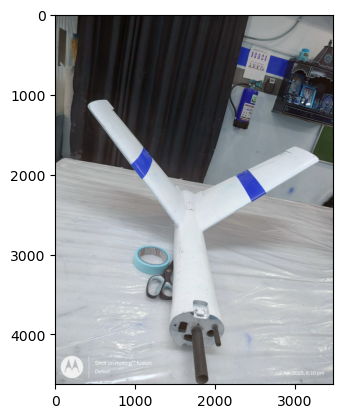

In [3]:
tail_img=cv.imread(r"D:\Data centr\IMG_data\UAV_Data\Tail\IMG_20250402_181055108_HDR.jpg")
plt.imshow(tail_img)

In [4]:
try:
    from skimage.morphology import skeletonize
except ImportError:
    skeletonize = None

try:
    from sklearn.cluster import KMeans
except ImportError:
    KMeans = None


def detect_tail_robust(img):
    h, w = img.shape[:2]
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (7,7), 0)

    # Binarize & find fuselage
    _, bw = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    cnts, _ = cv.findContours(bw, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    fus = max(cnts, key=cv.contourArea)
    fus_area = cv.contourArea(fus)
    if fus_area < (h*w)*0.005:
        return None

    # Fit line → pick lower endpoint as tail‐root
    pts = fus.reshape(-1,2)
    vx,vy,x0,y0 = cv.fitLine(pts, cv.DIST_L2,0,0.01,0.01).flatten()
    t = (pts[:,0]-x0)*vx + (pts[:,1]-y0)*vy
    end1, end2 = tuple(pts[np.argmin(t)]), tuple(pts[np.argmax(t)])
    tail_tip = end1 if end1[1] > end2[1] else end2

    # Make a circular ROI around that tip
    rad = int(max(h,w)*0.15)
    mask = np.zeros((h,w), np.uint8)
    cv.circle(mask, (int(tail_tip[0]), int(tail_tip[1])), rad, 255, -1)
    edges_roi = cv.Canny(blur, 50,150)
    edges_roi = cv.bitwise_and(edges_roi, edges_roi, mask=mask)
    bw_roi = cv.bitwise_and(bw, bw, mask=mask)

    # Contour‐based slender filter
    cnts2, _ = cv.findContours(edges_roi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    best = None; best_area = 0
    for c in cnts2:
        area = cv.contourArea(c)
        if area < fus_area*0.002:
            continue
        rect = cv.minAreaRect(c)
        (_, _),(bw_r,bh_r),_ = rect
        ar = max(bw_r,bh_r)/(min(bw_r,bh_r)+1e-5)
        if ar > 2.0 and area > best_area:
            best_area = area
            best = rect
    if best is not None:
        return cv.boxPoints(best).astype(int)

    # HoughLinesP ensemble
    if KMeans is not None:
        lines = cv.HoughLinesP(
            edges_roi, 1, np.pi/180, threshold=50,
            minLineLength=int(rad*0.4), maxLineGap=20
        )
        if lines is not None:
            pts_lin = []
            for x1,y1,x2,y2 in lines.reshape(-1,4):
                ang = abs(np.degrees(np.arctan2(y2-y1, x2-x1)))
                if (30 < ang < 60) or (120 < ang < 150):
                    pts_lin += [(x1,y1),(x2,y2)]
            if len(pts_lin) >= 4:
                kmeans = KMeans(n_clusters=2).fit(np.array(pts_lin))
                centers = kmeans.cluster_centers_
                rect = cv.minAreaRect(centers.astype(np.float32))
                return cv.boxPoints(rect).astype(int)

    # Skeleton + endpoints
    if skeletonize is not None:
        skel = skeletonize((bw_roi>0).astype(np.uint8))
        coords = np.column_stack(np.where(skel>0))
        endpoints = []
        for y,x in coords:
            block = skel[max(y-1,0):y+2, max(x-1,0):x+2]
            if block.sum()/255 == 2:
                endpoints.append((x,y))
        if len(endpoints) >= 3:
            maxd = 0; best_pair = None
            for i,p in enumerate(endpoints):
                for j,q in enumerate(endpoints):
                    d = (p[0]-q[0])**2 + (p[1]-q[1])**2
                    if d > maxd:
                        maxd = d
                        best_pair = (p,q)
            tips = np.array(best_pair, dtype=np.float32)
            rect = cv.minAreaRect(tips)
            return cv.boxPoints(rect).astype(int)

    # Harris corners clustering
    if KMeans is not None:
        try:
            dst = cv.cornerHarris(blur, 2,3,0.04)
            pts = np.argwhere(dst > 1.5*dst.mean())
            if len(pts) >= 2:
                kmeans = KMeans(n_clusters=2).fit(pts[:, ::-1])
                centroids = kmeans.cluster_centers_.astype(np.float32)
                rect = cv.minAreaRect(centroids)
                return cv.boxPoints(rect).astype(int)
        except Exception:
            pass
    return None


In [5]:
if __name__ == "__main__":
    box = detect_tail_robust(tail_img)
    if box is not None:
        cv.drawContours(tail_img, [box], -1, (0,255,0), 3)
        cv.imshow("Tail Detection", tail_img)
        cv.waitKey(0)
        cv.destroyAllWindows()
    else:
        print("No tail found")


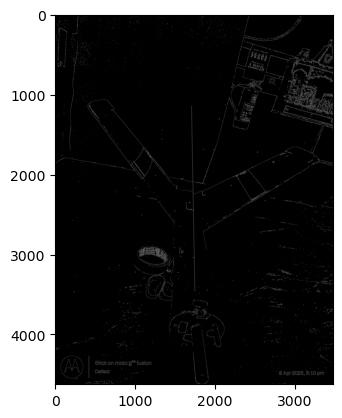

In [6]:
edges=cv.Canny(image=tail_img,threshold1=100, threshold2=150)
edges =cv.cvtColor(edges, cv.COLOR_BGR2RGB)  #threshold2: This is the second threshold for the hysteresis procedure.
edges =cv.cvtColor(edges, cv.COLOR_BGR2RGB)  
plt.imshow(edges)